In [50]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# G = nx.Graph()
# G = nx.read_gml('verified.gml')
G = nx.read_gml('datasets/verified.gml')

In [3]:
# nx.draw(G, with_labels=True, font_weight='bold')

In [4]:
G.number_of_nodes(), G.number_of_edges()

(2901, 148998)

In [5]:
# for line in nx.generate_edgelist(G):
#   print(line) 

In [6]:
# nx.write_edgelist(sub_g, "verified_edgelist.txt")

In [7]:
# gr = nx.read_edgelist("verified_edgelist.txt")

In [8]:
# !wget -c "https://www.dropbox.com/s/8isf9jcvl4dh1jw/vectors.csv"

In [9]:

df = pd.read_csv("datasets/verified_features_all_300k.csv")


In [10]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,1172796973,PTorresTV,548,1117,25,12136,0,0.0,0.0,0.312530,...,0.002391,0.021099,0.001657,0.001920,0.003702,0.000585,0.002335,0.002460,0.007839,0.011049
1,1070586199,EOnlineUK,353,102733,316,60989,0,0.0,0.0,0.301738,...,0.002308,0.021205,0.002619,0.002023,0.005247,0.000557,0.002802,0.002584,0.009525,0.013514
2,25589776,people,1751,7565880,33588,267090,1,0.0,0.0,0.324708,...,0.002769,0.032744,0.000474,0.001301,0.002765,0.000771,0.004536,0.005398,0.009638,0.008561
3,1367531,FoxNews,398,18416786,65345,418052,0,0.0,0.0,0.214538,...,0.002891,0.004289,0.001988,0.001589,0.001920,0.000191,0.003285,0.004726,0.002932,0.018821
4,20012204,usweekly,1177,2181224,11975,188328,1,0.9,0.5,0.264836,...,0.000750,0.035524,0.000372,0.002707,0.002477,0.000550,0.005693,0.001944,0.007702,0.008623


In [11]:
# intersected_df = pd.merge(df, 
#                           df_feat[['name', 'listed_count', 'statuses_count', 'desc_subjectivity', 'desc_polarity']]
#                           , how='inner')

In [12]:
# intersected_df.info()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2903 entries, 0 to 2902
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.5+ MB


In [14]:
# df = intersected_df

In [113]:
df = df[df['uid'] != 936040869878042624]

In [21]:
names = list(df['name'].values)

In [22]:
sub_g = G.subgraph(names)

In [23]:
sub_g.number_of_nodes(), sub_g.number_of_edges()

(2901, 148998)

In [24]:
# df[]
nodes = list(sub_g.nodes())

df = df[df['name'].isin(nodes)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2901 entries, 0 to 2902
Columns: 205 entries, uid to musical_empath
dtypes: float64(198), int64(6), object(1)
memory usage: 4.6+ MB


In [25]:
df = df[df['name'].isin(nodes)]
names = list(df['name'].values)


In [26]:
names[0]

'PTorresTV'

In [27]:
# int(df['fake'][df['name'] == names[0]])
len(names)

2901

In [28]:
G.node['PTorresTV']

{'ffr': 2.0383,
 'file': 'verified.dat',
 'followers': 1117,
 'friends': 548,
 'image': '/home/aveek/twitter2/img/1172796973.jpg',
 'lfr': 0.2238,
 'listed': 25,
 'shape': 'triangle-up',
 'statuses': 12136,
 'type': 'friends',
 'userid': '1172796973'}

In [29]:
for n in names:
    G.node[n]['fake'] = int(df['fake'][df['name'] == n])

In [31]:
# G.node['PTorresTV']
nx.write_gml(G, "datasets/verified_fake_labels.gml")

In [32]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True)

# pt = StandardScaler()

In [34]:
# values = df.drop(columns=['name', 'fake']).values
values = df.drop(columns=['name', 'fake', 'uid']).values

values_log = pt.fit_transform(values)

In [35]:
df = df.reindex(columns=['fake'] + [ x for x in df.columns if x!='fake'])

In [36]:
# df[df.columns[3:]]
# df[df.columns[2:]]

In [37]:
# df[df.columns[2:]] = values_log
df[df.columns[3:]] = values_log
df.head()

,fake,uid,name,friends_count,followers_count,listed_count,statuses_count,desc_subjectivity,desc_polarity,tweets_subjectivity,...,weapon_empath,children_empath,monster_empath,ocean_empath,giving_empath,contentment_empath,writing_empath,rural_empath,positive_emotion_empath,musical_empath
0,0,1172796973,PTorresTV,-0.582054,-2.119666,-2.234550,-1.295898,-0.913895,-0.426972,0.254521,...,0.406367,0.763588,3.025715,1.836441,0.862621,3.076810,-0.095552,0.513257,1.223009,0.979839
1,0,1070586199,EOnlineUK,-0.875083,0.407050,-0.443497,0.013688,-0.913895,-0.426972,0.191362,...,0.379360,0.768702,3.556915,1.903542,1.214578,2.984755,-0.002623,0.554156,1.410441,1.174976
2,1,25589776,people,0.368079,2.228206,2.312726,1.419851,-0.913895,-0.426972,0.324852,...,0.524213,1.211943,1.225343,1.350129,0.594292,3.590871,0.308841,1.260611,1.421453,0.733738
3,0,1367531,FoxNews,-0.798347,2.547462,2.652374,1.890806,-0.913895,-0.426972,-0.349589,...,0.560568,-0.408646,3.264151,1.596237,0.308552,1.245072,0.089344,1.125324,0.329907,1.473822
4,1,20012204,usweekly,0.011484,1.750877,1.761610,1.067464,1.608867,1.563065,-0.030689,...,-0.209424,1.291108,0.956071,2.268944,0.501842,2.960290,0.490076,0.331768,1.205752,0.740579


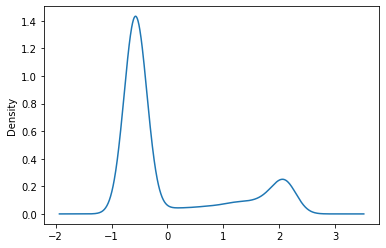

In [38]:
ax = plt.gca()

df['money_empath'].plot.kde()

plt.show()


In [39]:
df.index = df.index.map(str)
df = df.set_index('name')

In [40]:
df.index.names = [None]

In [114]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2900 entries, PTorresTV to LA_Beth
Columns: 204 entries, fake to musical_empath
dtypes: float64(202), int64(2)
memory usage: 4.5+ MB
None


In [115]:
# user_features
# train_data

In [116]:
df = df.astype({'fake': int})

In [117]:
user_features = df.drop(columns=['fake', 'uid'])
# user_features = df.drop(columns=['fake'])

user_target = df['fake']

In [118]:
train_data, test_data, train_targets, test_targets = train_test_split(user_features,
                                         user_target,
                                         test_size=0.2,
                                         random_state=1)

train_targets= train_targets.values.reshape((-1,1))
test_targets= test_targets.values.reshape((-1,1))


train_targets.shape, test_targets.shape, train_data.shape, test_data.shape

((2320, 1), (580, 1), (2320, 202), (580, 202))

In [119]:
stg = sg.StellarGraph(sub_g, node_features=df.drop(columns=['fake', 'uid']))

In [120]:
# generator = FullBatchNodeGenerator(stg, method="gcn", sparse=True)
# train_gen = generator.flow(train_data.index, train_targets, )

generator = GraphSAGENodeGenerator(stg, 50, [20, 10])
train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)

In [121]:
# from keras import layers, optimizers, losses, metrics, Model, models


In [122]:
# base_model = GCN(
#     layer_sizes=[32, 16],
#     generator = generator,
#     bias=True,
#     dropout=0.2,
#     activations=["elu", "elu"]
# )
# x_inp, x_out = base_model.node_model()
# prediction = layers.Dense(units=1, activation="sigmoid")(x_out)

base_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)
x_inp, x_out = base_model.default_model(flatten_output=True)
prediction = layers.Dense(units=1, activation="sigmoid")(x_out)

In [123]:

model = Model(inputs=x_inp, outputs=prediction)

In [124]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [125]:
test_gen = generator.flow(test_data.index, test_targets)

In [126]:
history = model.fit_generator(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    verbose=1,
#     shuffle=False,
)

Epoch 1/30
47/47 [==============================] - 12s 247ms/step - loss: 0.6600 - acc: 0.6117 - val_loss: 0.5962 - val_acc: 0.6914
Epoch 2/30
47/47 [==============================] - 10s 222ms/step - loss: 0.6066 - acc: 0.6911 - val_loss: 0.5807 - val_acc: 0.7052
Epoch 3/30
47/47 [==============================] - 3s 63ms/step - loss: 0.5856 - acc: 0.7022 - val_loss: 0.5747 - val_acc: 0.7138
Epoch 4/30
47/47 [==============================] - 12s 259ms/step - loss: 0.5753 - acc: 0.7115 - val_loss: 0.5989 - val_acc: 0.6810
Epoch 5/30
47/47 [==============================] - 3s 62ms/step - loss: 0.5750 - acc: 0.7159 - val_loss: 0.5640 - val_acc: 0.6966
Epoch 6/30
47/47 [==============================] - 3s 66ms/step - loss: 0.5738 - acc: 0.7122 - val_loss: 0.5762 - val_acc: 0.6897
Epoch 7/30
47/47 [==============================] - 3s 64ms/step - loss: 0.5562 - acc: 0.7274 - val_loss: 0.5530 - val_acc: 0.7276
Epoch 8/30
47/47 [==============================] - 3s 65ms/step - loss: 0.56

In [127]:

# test_metrics = model.evaluate_generator(test_gen)
# print("\nTest Set Metrics:")
# for name, val in zip(model.metrics_names, test_metrics):
#     print("\t{}: {:0.4f}".format(name, val))

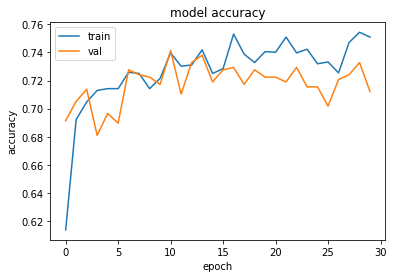

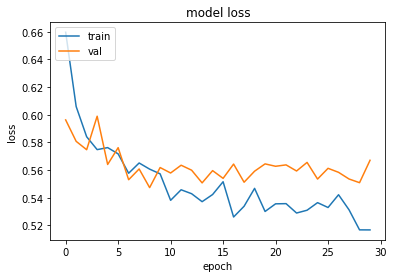

In [128]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [129]:

all_nodes = df.drop(columns=['fake','uid']).index
all_gen = generator.flow(all_nodes)

In [130]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [131]:
all_predictions.shape

(2900, 1)

In [132]:
# df.drop(columns=['fake'])

In [133]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=df.drop(columns=['fake','uid']).index)

In [134]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [135]:

test_preds.head()

,0
949ThePoint,0.060390
BBCBreaking,0.218509
987fm,0.836808
hburgamerican,0.082596
rachelsklar,0.774138


In [136]:
from numpy import isnan
test_predictions = test_preds.values
where_are_NaNs = isnan(test_predictions)
test_predictions[where_are_NaNs] = 0
test_predictions_class = ((test_predictions>=0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.7802497027348395


In [137]:
# test_df['Predicted_score'].values
# test_predictions_class
# test_df['True'].values

In [138]:

pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,182,108
1,51,239


In [139]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [140]:

print('Accuracy: %f' % accuracy_score(test_df['True'], test_df['Predicted_class']))
print('Precision: %f' % precision_score(test_df['True'], test_df['Predicted_class']))
print('Recall: %f' % recall_score(test_df['True'], test_df['Predicted_class']))
print('F1 score: %f' % f1_score(test_df['True'], test_df['Predicted_class']))

# confusion matrix
# print(confusion_matrix(test_df['True'], test_df['Predicted_class']))

Accuracy: 0.725862
Precision: 0.688761
Recall: 0.824138
F1 score: 0.750392
